# $\textit{In Silico}$ study of human upper arm arterial network

![](images/hand.png)

In [1]:
import os
from sys import argv
import numpy as np
import matplotlib.pyplot as plt
# path = "../"
# os.chdir(path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pylsewave.mesh import Vessel, VesselNetwork
from pylsewave.pdes import PDEm, PDEsWat, PDEsVisco
from pylsewave.bcs import BCs, BCsWat
from pylsewave.viz import PlotAndStoreSolution
from pylsewave.interpolate import CubicSpline
from pylsewave.nonlinearsolvers import Newton_system_conj_points
from pylsewave.fdm import BloodWaveMacCormack, BloodWaveLaxWendroff, BloodWaveMacCormackGodunov
from pylsewave.pwconsts import *
from pylsewave.pwutils import *

In [3]:
LANGUAGE="cy"

In [4]:
filename = "../data/Arterial_Network_ADAN56.txt"
data = np.loadtxt(filename, delimiter="&", dtype=np.str)
indexes = [7, 8, 9, 10, 11, 12, 13]  # create filter
data = data[indexes]

In [5]:
print(" \\\\\n".join([" & ".join(map(str, line)) for line in data]))

8  & Axilliary R  & 12.00  & 0.230  & 0.208  & 0.067  & 0.4  \\
9  & Brachial R  & 22.311  & 0.208  & 0.183  & 0.067  & 0.4  \\
10  & R. Radial  & 30.089  & 0.138  & 0.138  & 0.043  & 0.8  \\
11  & R. Ulnar\; I  & 2.976  & 0.141  & 0.141  & 0.046  & 0.8  \\
12  & R. Interosseous  & 1.627  & 0.096  & 0.096  & 0.028  & 1.6  \\
13  & Posterior interosseous R  & 23.056  & 0.068  & 0.068  & 0.028  & 1.6  \\
14  & R. Ulnar \;II  & 23.926  & 0.141  & 0.141  & 0.046  & 0.8 


### Simulation of upper extremity pulse wave propagation assuming a linear model for arterial walls

In [6]:
# Mynard
k = np.array([0.0865, 2.0, -2.253]) #[33.7e-03, 0.3, -0.9] old

nu = CONSTANT_MU_BLOOD/CONSTANT_RHO_BLOOD

T_cycle = 0.8
tc = 4
T = T_cycle*tc

dt = 1e-4

p0 = 0.
# -------- SEGMENTS ------------ #
segments = []
for i in range(data.shape[0]):
    segments.append(Vessel(name=data[i, 1], L=float(data[i, 2]) * 10.,
                           R_proximal=float(data[i, 3]) * 10.,
                           R_distal=float(data[i, 4]) * 10.,
                           Wall_thickness=float(data[i, 5]) * 10., Id=i))
    # set k vector
    segments[i].set_k_vector(k=k)

In [7]:
for ii in range(7):
    A0_distal = np.pi*((segments[ii].r_dist)**2)
    A0_prox = np.pi * (segments[ii].r_prox * segments[ii].r_prox)
    print("A0_distal is: ")
    print(A0_distal)
    print("A0_prox is: ")
    print(A0_prox)
    print("\n")

A0_distal is: 
13.591786456490883
A0_prox is: 
16.61902513749001


A0_distal is: 
10.520879637606859
A0_prox is: 
13.591786456490883


A0_distal is: 
5.982849049496403
A0_prox is: 
5.982849049496403


A0_distal is: 
6.245800354601867
A0_prox is: 
6.245800354601867


A0_distal is: 
2.895291789548353
A0_prox is: 
2.895291789548353


A0_distal is: 
1.4526724430199207
A0_prox is: 
1.4526724430199207


A0_distal is: 
6.245800354601867
A0_prox is: 
6.245800354601867




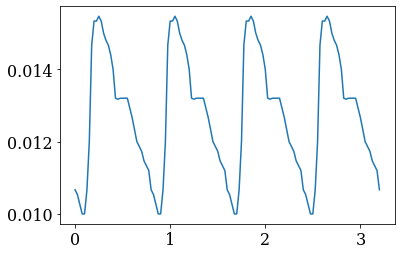

In [8]:

# -------  INFLOW (IN VIVO) WAVE  ------- #
invivo_data_brachial_p = np.loadtxt("../data/brachial_p_zambanini_invivo.txt", delimiter=",")
time_measured = invivo_data_brachial_p[:, 0]
pressure_measured = invivo_data_brachial_p[:, 1]*0.00013332239 # convert to MPa
time_periodic, pressure_periodic = convert_data_periodic(time_measured, pressure_measured, tc, True)

p_inlet_bc = CubicSpline(time_periodic, pressure_periodic)


In [9]:
# -------  TERMINAL VESSELS  ------- #
terminal_vessels = {2: [11539., 46155., 4.909e-06], 5: [47813., 191252., 1.185e-06],
                    6: [11749., 46995., 4.821e-06]}

for i in terminal_vessels.keys():
    terminal_vessels[i][0] = terminal_vessels[i][0]*1e-010
    terminal_vessels[i][1] = terminal_vessels[i][1]*1e-010
    terminal_vessels[i][2] = terminal_vessels[i][2]*1e+010

# -------  BIFURCATIONS  ------- #
bif_vessels = [[1, 2, 3],
               [3, 4, 6]]

# -------  CONJUCTIONS  ------- #
conj_points = [[0, 1],
               [4, 5]]

In [10]:

for i in terminal_vessels.keys():
    # calculate wave speed with empirical formula
    c0_distal = compute_c(segments[i].r_dist, k, CONSTANT_RHO_BLOOD)
#     print c0_distal
    A0_distal = np.pi*((segments[i].r_dist)**2)
    # R1 should be the same with the input characteristic impedance
    Z1_distal = (CONSTANT_RHO_BLOOD * c0_distal) / A0_distal
#     Z1_distal = terminal_vessels[i][0]
    R1 = terminal_vessels[i][0]
    R2 = terminal_vessels[i][1]
    C_t = terminal_vessels[i][2]
#     print Z1_distal - R2
    # add RLC data in each terminal vessel
    segments[i].RLC = {"R_1": Z1_distal, "R_t": R2, "C_t": C_t}


In [11]:

# create the Arterial Network domain/mesh
# Reflecting BCs
Nx = None
vesssel_network = VesselNetwork(vessels=segments, dx=2., Nx=Nx)

# give a name for the output database file
# casename = "/results/Hand_model_Python_10Nx_CFL05_Linear"
casename = "/results/Hand_model_Cython_10Nx_CFL05_Linear_junb"

# check CFL and set dx accordingly
siz_ves = len(vesssel_network.vessels)
compare_l_c0 = []
for i in range(siz_ves):
    c_max = np.max(compute_c(vesssel_network.vessels[i].r0, k, CONSTANT_RHO_BLOOD))
    A = np.pi * (vesssel_network.vessels[i].r_prox * vesssel_network.vessels[i].r_prox)
    compare_l_c0.append(vesssel_network.vessels[i].length / c_max)

min_value = min(compare_l_c0) # formula 76 case studies
index_min_value = np.argmin(compare_l_c0)
print("The min length to wave speed radio has been computed to Vessel: '%s' " % vesssel_network.vessels[
    index_min_value].name)

# Nx_i = 1
min_time = []
for i in range(siz_ves):
    Nx_i = 10 * np.floor((vesssel_network.vessels[i].length / compute_c(vesssel_network.vessels[i].r_prox, k, CONSTANT_RHO_BLOOD)) / (min_value))
    dx_i = vesssel_network.vessels[i].length / Nx_i
    vesssel_network.vessels[i].dx = dx_i
    min_time.append(dx_i / np.max(compute_c(vesssel_network.vessels[i].r0, k, CONSTANT_RHO_BLOOD)))

CFL = 0.5
dt = CFL * (min(min_time))
print(dt)

# callback function to store solution
number_of_frames = 800
skip = int(round(T / dt)) // number_of_frames
umin = 0.1
umax = 1.5
myCallback = PlotAndStoreSolution(casename=casename, umin=umin,
                                  umax=umax, skip_frame=skip,
                                  screen_movie=True, backend=None,
                                  filename='/results/tmpdata')

The min length to wave speed radio has been computed to Vessel: 'R. Interosseous ' 
5.555806726875247e-05


In [12]:


if LANGUAGE == "py":
    # Python classes linear
    # PDEs #
    myPDEs = PDEsWat(vesssel_network, rho=CONSTANT_RHO_BLOOD, mu=CONSTANT_MU_BLOOD)
    # BCS #
    myBCs = BCsWat(myPDEs, p_inlet_bc.eval_spline)
    U0_vessel = np.array([0], dtype=np.int)
    UL_vessel = np.array(list(terminal_vessels.keys()))
    UBif_vessel = np.array(bif_vessels)
    UConj_vessel = np.array(conj_points)

    mySolver = BloodWaveMacCormack(myBCs)
    mySolver.set_T(dt=dt, T=T, no_cycles=tc)
    mySolver.set_BC(U0_vessel, UL_vessel, UBif_vessel, UConj_vessel)
    mySolver.solve(casename, myCallback)
    myCallback.close_file(casename)

elif LANGUAGE == "cy":
    from pylsewave.cynum import cPDEsWat, cBCsWat, cMacCormackSolver
    myPDEs = cPDEsWat(vesssel_network, rho=CONSTANT_RHO_BLOOD, mu=CONSTANT_MU_BLOOD)
    myBCs = cBCsWat(myPDEs, p_inlet_bc.eval_spline)

    U0_vessel = np.array([0],dtype=np.int64)
    UL_vessel = np.array(list(terminal_vessels.keys()), dtype=np.int64)
    UBif_vessel = np.array(bif_vessels, dtype=np.int64)
    UConj_vessel = np.array(conj_points, dtype=np.int64)

    mySolver = cMacCormackSolver(myBCs)
    mySolver.set_T(dt=dt, T=T, no_cycles=tc)
    mySolver.set_BC(U0_vessel, UL_vessel, UBif_vessel, UConj_vessel)
    %time mySolver.solve(myCallback)
    myCallback.close_file(casename)
    

Solver set to dt=0.000055558
('Size of solution is:', 812)
Writing solution to file...
Writing solution to file completed!
Wall time: 1min 14s
[-] Cleaning temporary files...
Archive name: ./results/Hand_model_Cython_10Nx_CFL05_Linear_junb_archive.npz


### Post-processing

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pylsewave.postprocessing import ExtractUVectors

In [14]:
myodbf = ExtractUVectors("./results/Hand_model_Cython_10Nx_CFL05_Linear_junb_archive.npz")

# sampling frequency
fr = 1 # kHz
sampling_period = 0.001
no_points = int(1.0 / 0.001) + 1 #1001

vessels_plot = {i: data[i][1] for i in range(len(data))}
#print(" \\\\\n".join([" & ".join(map(str, line)) for line in data]))

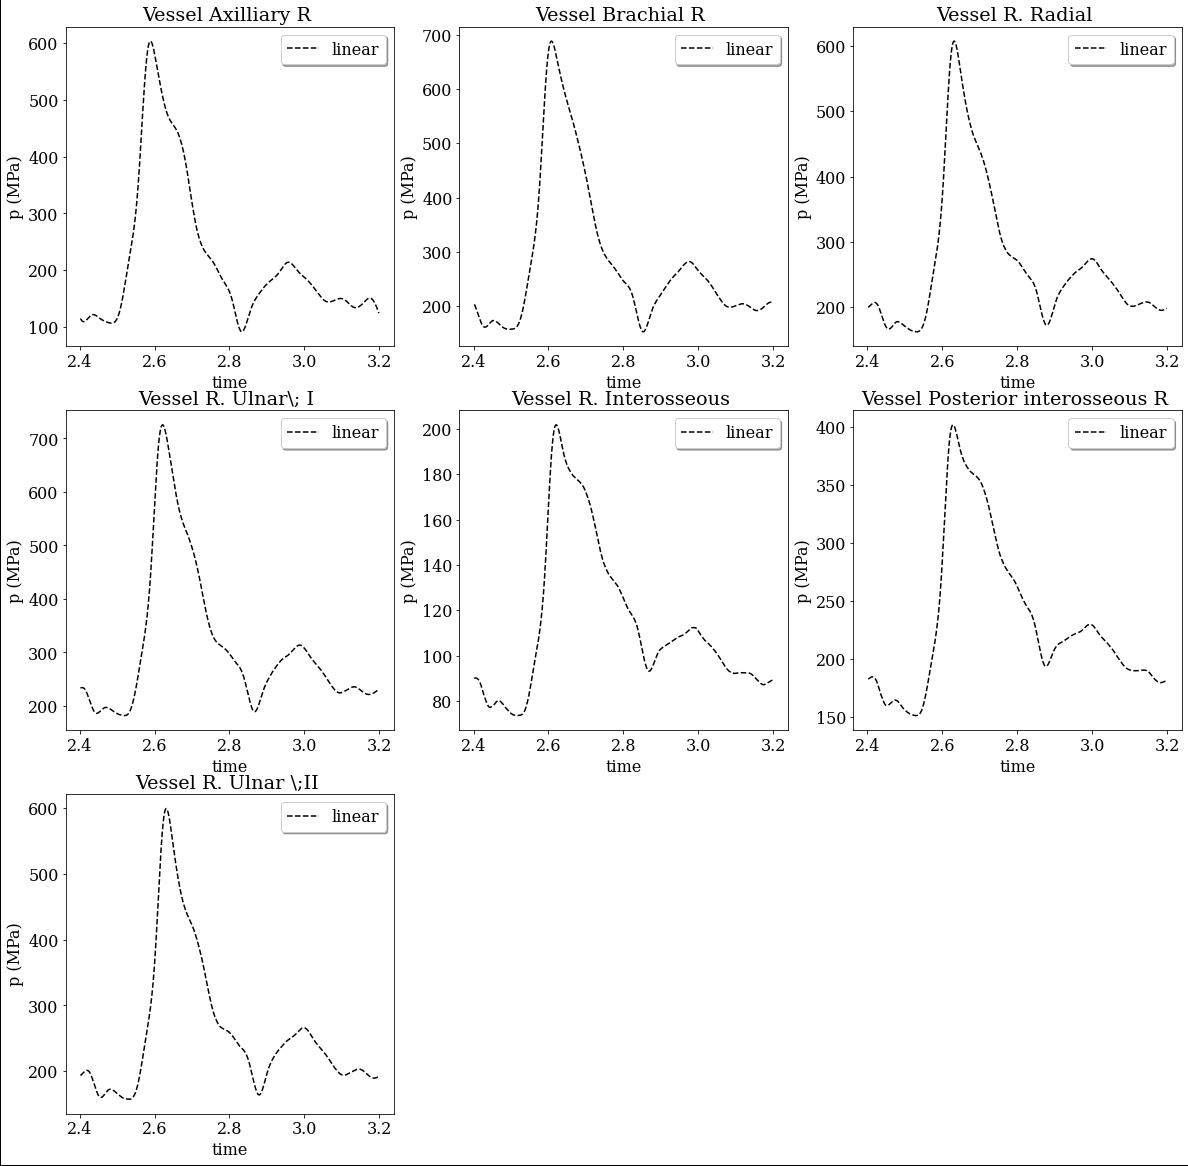

In [15]:
# pressure at different vessels
figbra = plt.figure(figsize=(20, 20), facecolor='w', edgecolor='k',
                    linewidth= 2.0, frameon=True)

ax_i = []
for i in (list(vessels_plot.keys())):
    ax_i.append(figbra.add_subplot(3, 3, i+1))
    A_b, q_b, p_b, u_b = myodbf.getUVector(vessel_no=i, cycle=4, no_points=no_points) #prende no_points di tempi e spazio e interpola le varie misure
    #A_v, q_v, p_v, u_v = myodbf_v.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    T_i = myodbf.meshgrid_T
    X_i = myodbf.meshgrid_X
    
    # create a dictionary with: Time, Pressure, Velocity, Area and Flow
    # I take the middle point
    ves_train = {
       "Time" : T_i[0,:],
       "Pressure" : p_b[500,:],
       "Velocity" : u_b[500,:],
       "Area" : A_b[500,:],
       "Flow" : q_b[500,:] 
    }
    
    ves_test = {
       "Time" : T_i[0,:],
       "Pressure" : p_b[800,:],
       "Velocity" : u_b[800,:],
       "Area" : A_b[800,:],
       "Flow" : q_b[800,:] 
    }
    with open("input_%d.npy" % (i+1), 'wb') as f:
        np.save(f, ves_train)
    with open("test_%d.npy" % (i+1), 'wb') as f:
        np.save(f, ves_test)
        
    
    p_plot = ax_i[i].plot(T_i[0, :], u_b[500, :], "k--", label="linear")
#     p_plot = ax_i[i].plot(T_i[0, :] - 3.0, p_b[500, :], "b--", label="linear")
#     p_plot = ax_i[i].plot(T_i[0, :], u_b[500, :], "k--", label="linear")
#     p_plot = ax_i[i].plot(T_i[0, :], p_b[500, :], "b--", label="linear")
#     p_plot = ax_i[i].plot(T_i[0, :] - 3.0, u_b[800, :], "k--", label="linear")
#     p_plot = ax_i[i].plot(T_i[0, :] - 3.0, p_b[800, :], "b--", label="linear")
#     p_plot = ax_i[i].plot(T_i[0, :], u_b[800, :], "k--", label="linear")
#     p_plot = ax_i[i].plot(T_i[0, :], p_b[800, :], "b--", label="linear")
   # p_plot = ax_i[i].plot(T_i[400, :] - 3.0, p_v[400, :], "r-", label="visco-el")
    ax_i[i].set_xlabel("time")
    ax_i[i].set_ylabel("p (MPa)")
    ax_i[i].set_title("Vessel %s" % vessels_plot[i])
    ax_i[i].legend(loc='best', ncol=1,
                   fancybox=True, shadow=True)
    
# plt.legend(loc='upper center', scatterpoints=1, ncol=1,
#            fancybox=True, bbox_to_anchor=(0.5, -0.03),
#            shadow=True)
# plt.savefig('plot3p.png', dpi=300, facecolor='w', edgecolor='w',
#             # orientation='portrait', papertype=None,
#             format='png', transparent=False, bbox_inches='tight',
#             # pad_inches=0.1,
#             frameon=None)
plt.show()